<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/Si-atom-dynamics-in-graphene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for paper "Atomic mechanisms for the Si  atom dynamics in graphene"

Prepared in Google Collaboratory by Maxim Ziatdinov (last update - 11/16/2018)

Contact e-mail: ziatdinovmax@gmail.com

---

This is a Jupyter (Colab) notebook for the following paper:

Paper title: Atomic mechanisms for the Si  atom dynamics in graphene: chemical transformations at the edge and in the bulk.

Authors: Maxim Ziatdinov, Ondrej Dyck, Stephen Jesse, and Sergei V. Kalinin

Current paper status: submitted

---

The goal of this notebook is to show how the scientific results presented in the paper were obtained as well as the overall logic behind the 'data analytics' part of the paper.

---

Brief description of the notebook content: 

Here, a deep neural network was trained and used to convert scanning transmission elelctron microscopy (STEM) movies into coordinates of individual Si and carbon atoms at the edges of graphene nanoholes. A Gaussian mixture model was further used in combination with structure similarity measurement to establish the elementary atomic configurations of the Si atoms, defining the bonding geometries and chemical species and accounting for the discrete rotational symmetry of the host lattice. Finally, the frequencies and Markov transition probabilities between the discovered states were determined.




## Set up google colab & import modules

One of many things I like about google colaboratory is that it allows to run Jupyter notebooks directly from a google drive, just like google docs, which I find very convenient (you may even run it from your smartphone). Therefore, we are going to save/load models and data to/from directly our google drive:

In [0]:
from google.colab import drive

drive.mount('/content/drive')

print('\nroot directory:')
!ls -al

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

root directory:
total 20
drwxr-xr-x 1 root root 4096 Dec  4 23:49 .
drwxr-xr-x 1 root root 4096 Dec  4 23:45 ..
drwxr-xr-x 1 root root 4096 Dec  3 17:43 .config
drwx------ 3 root root 4096 Dec  4 23:49 drive
drwxr-xr-x 2 root root 4096 Dec  3 17:43 sample_data


Now we can set a working directory in a google drive. Let's call it AI-STEM:

In [0]:
import os

path = 'drive/My Drive/Colab Notebooks/AI-STEM/'

if not os.path.exists(path):
    os.makedirs(path)  

os.chdir(path)

Let's also install libraries that we will use for model visualization (google colab doesn't have them by default):

In [0]:
%%capture
!pip install -q pydot
!apt-get install graphviz -y
import pydot

Import necessary modules:

In [0]:
import time

import tensorflow as tf
import numpy as np
import h5py
import json
from sklearn.utils import shuffle

from IPython.display import SVG
import cv2
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

## Create and train a mixed scale fully convolutional neural network

Create class *generate_batches* for feeding training/test data into a neural network from a large hdf5 file. This assumes a simple hdf5 file structure where train/test images are stored as 'X_train'/'X_test' and corresponding groundtruth (labels) are stored as 'y_train/y_test'.

In [0]:
class generate_batches:
    '''Creates a batch generator'''
    
    def __init__(self, hf_file, batch_size):
        '''Initializes a `batch generator`'''
        
        self.f = h5py.File(hf_file, 'r')
        self.batch_size = batch_size
  
    
    def steps(self, mode = 'training'):
        """Estimates number of steps per epoch"""
          
        if mode == 'val':
            n_samples = self.f['X_test'][:].shape[0]
        else:        
            n_samples = self.f['X_train'][:].shape[0]
        
        return n_samples//self.batch_size
    
    
    def batch(self, mode = 'training'):
        """Generates batch of the selected size
        for training images and the corresponding
        ground truth"""

        j = 0

        arr = np.arange(self.steps(mode))
        arr = shuffle(arr)

        while 1:

            if j == len(arr):
                j = 0    
                arr = shuffle(arr)

            i = arr[j]

            if mode == 'val':
                X_batch = self.f['X_test'][int(i*self.batch_size):int((i+1)*self.batch_size)]
                y_batch = self.f['y_test'][int(i*self.batch_size):int((i+1)*self.batch_size)]
            else:
                X_batch = self.f['X_train'][int(i*self.batch_size):int((i+1)*self.batch_size)]
                y_batch = self.f['y_train'][int(i*self.batch_size):int((i+1)*self.batch_size)]
            
            j += 1
            
            yield X_batch, y_batch
            
    
    def close_(self):
        """Closes h5 file"""
        
        if self.f:
            self.f.close()
            self.f = None

Create class *atomsegnet* for constructing a neural network for "atomic segmentation":

In [0]:
class atomsegnet:
    '''Builds  a fully convolutional
       neural network model'''
    
    
    def __init__(self, input_shape, nb_classes, lrelu_a = 0.01, use_batchnorm = True):
        '''Initializes a model builder'''
        
        self.lrelu_a = lrelu_a
        self.nb_classes = nb_classes
        self.use_batchnorm = use_batchnorm
        self.input_shape = input_shape        
    
    
    def pixelwise_class(self, input_tensor, activation = 'softmax'):
        '''Performs a pixel-wise classification'''
        
        x = tf.keras.layers.Conv2D(self.nb_classes, (3, 3), padding='same')(input_tensor)  
        x = tf.keras.layers.Activation(activation)(x)
        
        return x
      
      
    def convblock(self, input_tensor, nb_filters, mode = 'conv', pooling = None):
        """Creates a block consisting of i) convolutional
        or transpose convolutional layer, ii) leaky relu and
        (optionally) iii) batch normalization and iv) max pooling"""
        
        if mode == 'transpose_conv':
            x = tf.keras.layers.Conv2DTranspose(
                nb_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
        else:    
            x = tf.keras.layers.Conv2D(nb_filters, (3, 3), padding = 'same')(input_tensor) 
        
        x = tf.keras.layers.LeakyReLU(alpha = self.lrelu_a)(x)
        
        if self.use_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        
        if pooling == 'down':
            x_ = tf.keras.layers.MaxPooling2D((2, 2), padding = 'same')(x)
            return x, x_

        return x
    
    
    def dilated_layers(self, input_tensor, nb_filters, depth):
        '''Creates a block with dilated convolutional 
           layers (aka atrous convolutions)'''
       
        dilated_layers = []
        for i in depth:
            x = tf.keras.layers.Conv2D(
                nb_filters, (3, 3), padding = 'same', dilation_rate = i)(input_tensor)
            x = tf.keras.layers.LeakyReLU(alpha = self.lrelu_a)(x)
            if self.use_batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)
            dilated_layers.append(x)
        
        return tf.keras.layers.add(dilated_layers)
    
    
    def input_layer(self):
        '''Creates input layer'''
        
        return tf.keras.layers.Input(shape=self.input_shape)     
        
    
    def skip_connect(self, input_tensor1, input_tensor2):
        '''Performs a concatenation of two
           tensors along the last dimension'''
        
        return tf.keras.layers.concatenate([input_tensor1, input_tensor2])

    
    def build_model(self, input_, output_):
        '''Instantiate a model'''
         
        return tf.keras.models.Model(input_, output_)

We define a number of classes and specify input/target shape. Notice that for your model to work with images of variable size without down/up-sampling them, you should use (None, None, 1).

In [0]:
# Number of classes:
nb_classes = 3
# Input shape. For a model to work with images of variable size use (None, None, 1).
input_shape = (256, 256, 1)

Let's initialize our model. It will have a contracting path consisting of regular convolutional operations followed by max-pooling operation, a bottleneck layer with three layers of atrous convolutions with different dilation rates, and an expanding path with transpose convolutional layers. The final layer provides a pixel wise classifciation of the input data. Notice that when we use " pooling = 'down' " option,  both the downsampled tensor and the original one (before downsampling) are returned. The information from the latter will be fed into expanding path using skip connections. 

In [0]:
m = atomsegnet(input_shape, nb_classes)

# Create an input layer
input_layer = m.input_layer()

# Contracting path
c1 = m.convblock(input_layer, 32)
c1, p1 = m.convblock(c1, 32, pooling = 'down')   

c2 = m.convblock(p1, 64)
c2, p2 = m.convblock(c2, 64, pooling = 'down')

c3 = m.convblock(p2,128)
c3, p3 = m.convblock(c3, 128, pooling = 'down')

# Bottleneck
b0 = m.dilated_layers(p3, 256, depth = [2, 4, 6])

# Expanding path
u1 = m.convblock(b0, 128, mode = 'transpose_conv')
d1 = m.skip_connect(u1, c3)
d1 = m.convblock(d1, 128) 

u2 = m.convblock(d1, 64,  mode = 'transpose_conv')
d2 = m.skip_connect(u2, c2)
d2 = m.convblock(d2, 64)   

u3 = m.convblock(d2, 32,  mode = 'transpose_conv')
d3 = m.skip_connect(u3, c1)
d3 = m.convblock(d3, 32)

# Perform pixel-wise classification
output = m.pixelwise_class(d3)

# Build a model
model = m.build_model(input_layer, output)

We can plot the architecture of the model that we've just created:

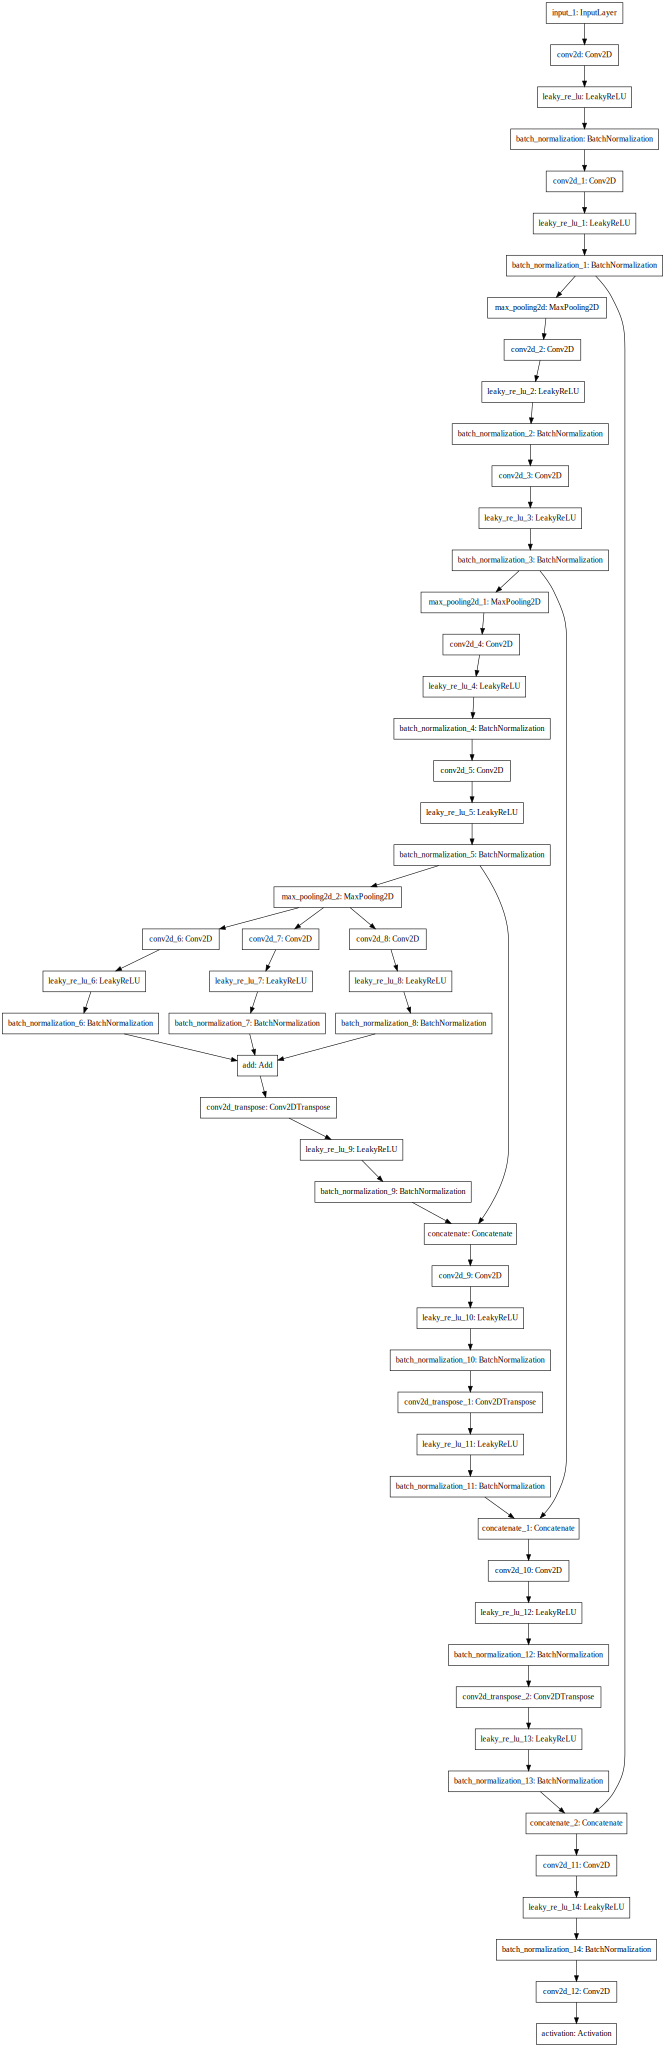

In [0]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

We are now going to train a model for finding atoms in a disordered graphene lattice. First we define a path to an hdf5 file with training/test data and a batch size:

In [0]:
# Training data filepath:
hf_file = 'G-trn1928-tst1827.hdf5'
# batch size:
batch_size = 64

Initialize a batch generator and produce a batch of training images with corresponding ground truth:

In [0]:
gen = generate_batches(hf_file, batch_size)
train_imgs, gt = next(gen.batch())
gen.close_()

Plot a {training image - ground truth} pair::

Text(0.5,1,'Ground truth')

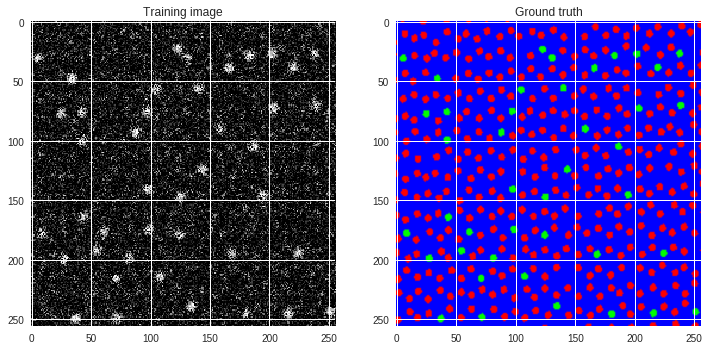

In [0]:
k = -1
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(121)
ax1.imshow(train_imgs[k, :, :, 0], cmap = 'gray')
ax1.set_title('Training image')
ax2 = fig.add_subplot(122)
ax2.imshow(gt[k], Interpolation = 'Gaussian')
ax2.set_title('Ground truth')

Now let's select whether we want to train our model using GPU or TPU:

In [0]:
def compile_model(hard_acc, model):
    '''Compiles a model with either
    GPU or TPU hardware acceleration'''
    
    if hard_acc == 'TPU':

        try:
            model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=tf.contrib.tpu.TPUDistributionStrategy(
                    tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))
        except KeyError:
            print("To run your model on TPU please select TPU in Runtime --> Change Runtime Type")

    else:

        if tf.test.gpu_device_name() == '/device:GPU:0':
            print(device_lib.list_local_devices()[2:])
        else:
            print("To run your model on GPU please select GPU in Runtime --> Change Runtime Type")

    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics = ['categorical_accuracy'])  
    return model

In [0]:
hard_acc = 'TPU'
model_c = compile_model(hard_acc, model)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.22.24.50:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11478808645836918276)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6518805178649401446)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17689355245283754249)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1206529241991997257)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6377937342908718622)
INFO:tensorflow:*** Available Device: _DeviceA

Now finally let's train our model:

In [0]:
gen = generate_batches(hf_file, batch_size)

model_c.fit_generator(gen.batch(),
                    epochs = 16, 
                    steps_per_epoch = gen.steps(),
                    validation_data = gen.batch(mode = 'val'),
                    validation_steps = gen.steps(mode = 'val'))

Epoch 1/16
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name='activation_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 18.136701583862305 secs
INFO:tensorflow:Setting weights on TPU model.
34/35 [============================>.] - ETA: 6s - loss: 0.5553 - categorical_accuracy: 0.8428 INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name='activation_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensor

Copy TPU weights to CPU and save them:

In [0]:
model_c.save_weights('Weights'+str(hf_file.split('.')[0])+'-test.h5', overwrite=True)

INFO:tensorflow:Copying TPU weights to the CPU


We can plot train/test loss (or we can plot train/test accuracy):

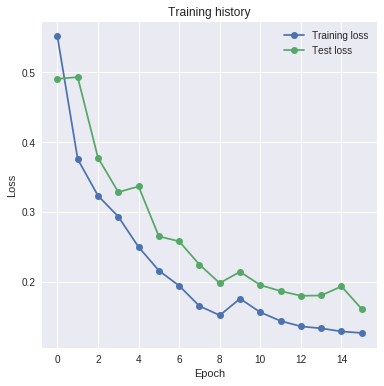

In [0]:
plt.figure(figsize=(6, 6))
plt.plot(model_c.history.history['loss'], '-o', label = 'Training loss')
plt.plot(model_c.history.history['val_loss'], '-o', label = 'Test loss')
plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')

Load weights into model that we defined (prior to training) so that we can make predictions using CPU:

In [0]:
prediction_model = model
prediction_model.load_weights('Weights'+str(hf_file.split('.')[0])+'-test.h5')
prediction_model.save('Model-'+str(hf_file.split('.')[0])+'-test.h5')

Let's see how the trained model performs on test data:

In [0]:
X_test, y_test = next(gen.batch(mode = 'val'))
gen.close_()

In [0]:
X_pred = prediction_model.predict(X_test)

Text(0.5,1,'Model prediction')

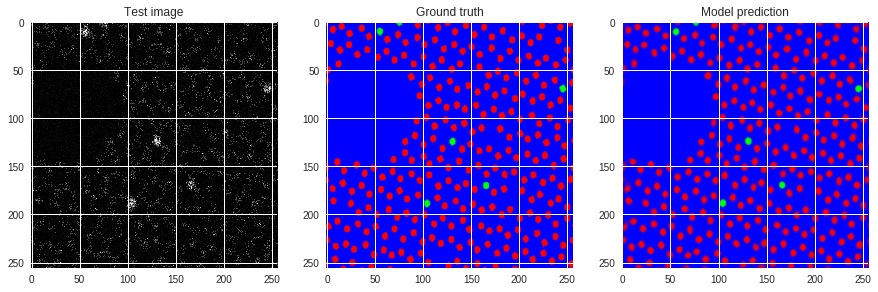

In [0]:
k = 2
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(131)
ax1.imshow(X_test[k, :, :, 0], cmap = 'gray')
ax1.set_title('Test image')
ax2 = fig.add_subplot(132)
ax2.imshow(y_test[k], Interpolation = 'Gaussian')
ax2.set_title('Ground truth')
ax3 = fig.add_subplot(133)
ax3.imshow(X_pred[k], Interpolation = 'Gaussian')
ax3.set_title('Model prediction')

Now let's see how the same model works for experimental data:

## Finding atoms and edge contours

We will now apply a trained model to analyzing noisy STEM data on graphene with disorder.

### Finding lattice atoms and impurities
We start with locating all atoms in a dataset. Note that if you have a trained model already, you can run this part of a notebook separately from a previous part (just make sure all pre-steps like mounting your google drive and importing necessary modules are completed first).

Create class *dl_image* to process and decode (make prediction) input experimental data:

In [0]:
class dl_image:
    '''Image decoder with a trained neural network'''
    
    def __init__(self, image_data, model, *args, nb_classes = 3, max_pool_n = 3, norm = 1):
        '''Initialize a decoder'''
        
        # Input data must be either an image stack or a single image (all greyscale)
        if image_data.ndim == 2:
            image_data = np.expand_dims(image_data, axis = 0)
        self.image_data = image_data  
        try:
            self.rs = args[0]
        except IndexError:
            self.rs = image_data.shape[1:3]
        self.model = model
        self.nb_classes = nb_classes
        self.max_pool_n = max_pool_n
        self.norm = norm
        
    
    def img_resize(self):
        '''Image resizing (optional)'''
             
        if self.image_data.shape[1:3] == self.rs:
            return self.image_data.copy()
            
        image_data_r = np.zeros((self.image_data.shape[0], self.rs[0], self.rs[1]))
        for i, img in enumerate(self.image_data):
            img = cv2.resize(img, (self.rs[0], self.rs[1]))
            image_data_r[i, :, :] = img
            
        return image_data_r
        
    def img_pad(self, *args):
        '''Pads the image if its size (w = h)
        is not divisible by 2**n, where n is a number
        of max-pooling layers in a network'''
        
        try:
            image_data_p = args[0]
        except IndexError:
            image_data_p = self.image_data
            
        while image_data_p.shape[1] % 2**self.max_pool_n != 0:
            d0, d1, d2 = image_data_p.shape
            image_data_p = np.concatenate((image_data_p, np.zeros((d0, 1, d2))), axis = 1)
            image_data_p = np.concatenate((image_data_p, np.zeros((d0, d1+1, 1))), axis = 2)

        return image_data_p
    

    def tf_format(self):
        '''Reshapes and normalizes (optionally) image data
        to make it compatible with keras/tensorflow format'''
        
        image_data_ = self.img_resize()
        image_data_ = self.img_pad(image_data_)
        image_data_ = np.expand_dims(image_data_, axis = 3)
        image_data_ = image_data_.astype('float32')
        if self.norm != 0:
            image_data_ = (image_data_ - np.amin(image_data_))/np.ptp(image_data_)
        return image_data_
    
    
    def predict_(self):
        '''Make prediction'''
        
        image_data_tf = self.tf_format()
        try: 
            start_time = time.time()
            decoded_imgs = self.model.predict(image_data_tf)
        except:
            start_time = time.time()
            n, w, h, _ = image_data_tf.shape
            decoded_imgs = np.zeros((n, w, h, self.nb_classes))
            for i in range(image_data_tf.shape[0]):
                decoded_imgs[i,:,:,:] = self.model.predict(image_data_tf[i:i+1])          
        n_images_str = " image was " if decoded_imgs.shape[0] == 1 else " images were "
        print(str(decoded_imgs.shape[0]) + n_images_str + "decoded in approximately " + str(np.around(time.time() - start_time, decimals = 2)) + ' seconds')
        return image_data_tf, decoded_imgs

Creat class *find_atoms* to extract coordinates of atoms from the decoded data:

In [0]:
class find_atoms:
    '''Transforms pixel data from decoded images
    into  a structure 'file' of atoms coordinates'''
    
    def __init__(self, decoded_imgs, threshold = 0.6, verbose = 1):
        self.decoded_imgs = decoded_imgs
        self.threshold = threshold
        self.verbose = verbose
        
               
    def get_all_coordinates(self, dist_edge = 5):
        '''Extract all atomic coordinates in image
        via CoM method & store data as a dictionary
        (key: frame number)'''
        
        def find_com(image_data):
            '''Find atoms via center of mass methods'''

            labels, nlabels = ndimage.label(image_data)
            coordinates = np.array(ndimage.center_of_mass(image_data, labels, np.arange(nlabels)+1))
            coordinates = coordinates.reshape(coordinates.shape[0], 2)
            return coordinates

        d_coord = {}
        for i, decoded_img in enumerate(self.decoded_imgs):
            coordinates = np.empty((0,2))
            category = np.empty((0,1))
            for ch in range(decoded_img.shape[2]-1): # we assume that class 'background' is always the last one
                _, decoded_img_c = cv2.threshold(decoded_img[:,:,ch], self.threshold, 1, cv2.THRESH_BINARY)
                coord = find_com(decoded_img_c)
                coord_ch = self.rem_edge_coord(coord, dist_edge)
                category_ch = np.zeros((coord_ch.shape[0], 1))+ch  
                coordinates = np.append(coordinates, coord_ch, axis = 0)
                category = np.append(category, category_ch, axis = 0)
            d_coord[i] = np.concatenate((coordinates, category), axis = 1)
        if self.verbose == 1:    
            print("Atomic/defect coordinates extracted.\n")        
        
        return d_coord
    

    def rem_edge_coord(self, coordinates, dist_edge):
        '''Remove coordinates at the image edges; can be applied
           to coordinates without image as well (use Image = None 
           when initializing "find_atoms" class)'''
        
        def coord_edges(coordinates, w, h, dist_edge):
            
            return [coordinates[0] > w - dist_edge,
                    coordinates[0] < dist_edge,
                    coordinates[1] > h - dist_edge,
                    coordinates[1] < dist_edge]
        
        if self.decoded_imgs is not None:
            if self.decoded_imgs.ndim == 3:
                w, h = self.decoded_imgs.shape[0:2]
            else:
                w, h = self.decoded_imgs.shape[1:3]      
        else:
            w = np.amax(coordinates[:,0] - np.amin(coordinates[:,0]))
            h = np.amax(coordinates[:,1] - np.amin(coordinates[:,1]))
            
        coord_to_rem = [idx for idx, c in enumerate(coordinates) if any(coord_edges(c, w, h, dist_edge))]
        coord_to_rem = np.array(coord_to_rem, dtype = int)
        coordinates = np.delete(coordinates, coord_to_rem, axis = 0)
        
        return coordinates

Load experimental data:

In [0]:
foldername = './'
filename = 'Wobbly2-raw-exp.npy'
STEM_real = np.load(foldername+filename)
print(STEM_real.shape)

(300, 256, 256)


Visualize an individual frame as well as average over all frames in the upladed movie:

Text(0.5,1,'Experimental (averaged)')

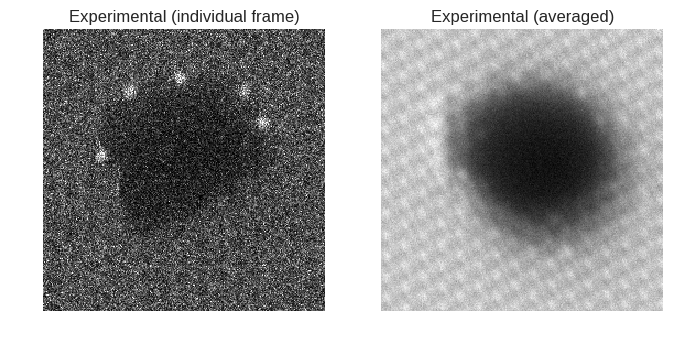

In [0]:
i = 11

fig = plt.figure(figsize = (8, 8), dpi = 100)
ax1 = fig.add_subplot(121)
ax1.imshow(STEM_real[i], cmap = 'gray')
ax1.axis('off')
ax1.set_title('Experimental (individual frame)')
ax2 = fig.add_subplot(122)
ax2.imshow(np.mean(STEM_real, axis = 0), cmap = 'gray')
ax2.axis('off')
ax2.set_title('Experimental (averaged)')

Load a trained model:

In [0]:
prediction_model = tf.keras.models.load_model("Model-G-trn1928-tst1827.h5")

Make predictions for experimental image stack:

(here we use CPU for predictions)

In [0]:
STEM_real_, decoded_imgs = dl_image(STEM_real, prediction_model).predict_()

300 images were decoded in approximately 144.22 seconds


Extract coordinates:

In [0]:
lattice_coord = find_atoms(decoded_imgs).get_all_coordinates()

Atomic/defect coordinates extracted.



Plot results:

Text(0.5,1,'Atomic coordinates')

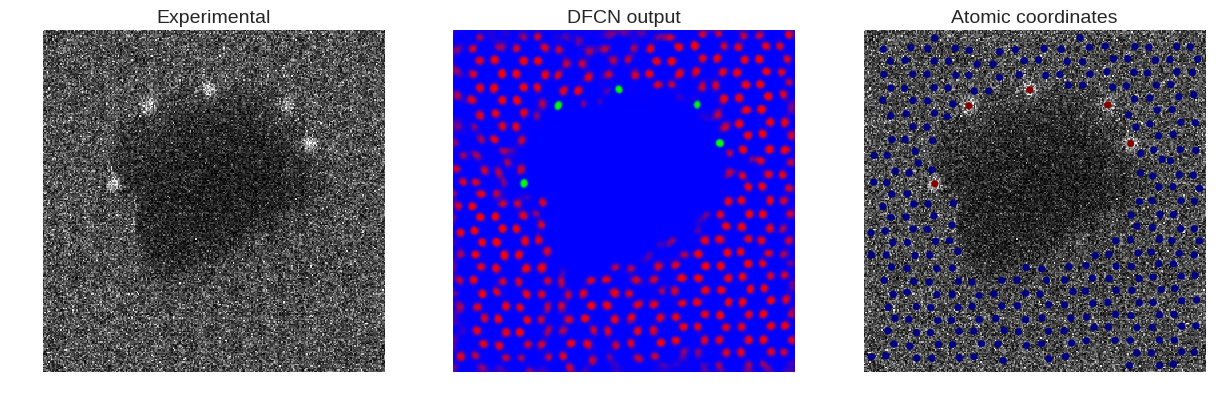

In [0]:
i = 11
lattice_coord_ = lattice_coord[i]

fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real_[i,:,:,0], cmap = 'gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize = 14)
ax2 = fig.add_subplot(132)
ax2.imshow(decoded_imgs[i], cmap = 'seismic', Interpolation = 'Gaussian')
ax2.axis('off')
ax2.set_title('DFCN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(lattice_coord_[:,1], lattice_coord_[:,0], c = lattice_coord_[:,2], cmap = 'jet', s = 25)
ax3.imshow(STEM_real_[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

### Find edge contours

We will now use information from the third channel of DL output to find edge contours:

Define some helper functions:

In [0]:
from scipy import interpolate

def filter_isolated_cells(imgdata, th):
    label_img, cc_num = ndimage.label(imgdata)
    CC = ndimage.find_objects(label_img)
    cc_areas = ndimage.sum(imgdata, label_img, range(cc_num+1))
    area_mask = (cc_areas < th)
    label_img[area_mask[label_img]] = 0
    label_img[label_img > 0] = 1
    return label_img
  
def interp_spline(coord, s = 100):
    tck, u = interpolate.splprep(coord, s = s, per=False)
    xi, yi = interpolate.splev(np.linspace(0, 1, 500), tck)
    coord_i = np.array([xi, yi]).T
    return coord_i

Get a segmented hole shape for an individual frame:

(-0.5, 255.5, 255.5, -0.5)

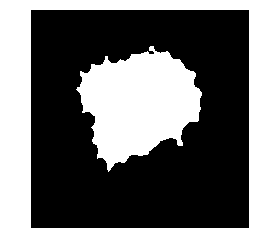

In [0]:
k = 11
img_cnt = decoded_imgs[k,:,:,2]
img_cnt = ndimage.filters.gaussian_filter(img_cnt,2.5)
img_cnt = img_cnt/np.amax(img_cnt)
_, thresh = cv2.threshold(img_cnt, 0.99, 1, cv2.THRESH_BINARY)
t = filter_isolated_cells(thresh, 1000)
plt.imshow(t, cmap = 'gray')
plt.axis('off')

Find and plot a corresponding contour:

In [0]:
t = cv2.convertScaleAbs(t)
image, contours_i, hierarchy = cv2.findContours(t.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 

c_x = np.array([a[0][1] for a in contours_i[0]])
c_y = np.array([a[0][0] for a in contours_i[0]])
contour = np.concatenate((c_x[:,None], c_y[:,None]), axis = 1)

contour_spl = interp_spline(contour.T, s = 3500)

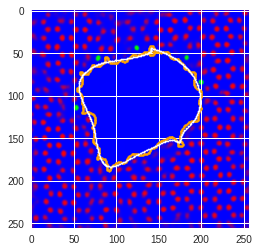

In [0]:
plt.imshow(decoded_imgs[k], Interpolation = 'Gaussian')
plt.scatter(contour[:,1], contour[:,0], c = 'orange', s = 4)
plt.scatter(contour_spl[:,1], contour_spl[:,0], c = 'white', s = 1.5)

Now do the same for all frames:

In [0]:
from collections import OrderedDict

dictionary_all = {}
for idx, decoded in enumerate(decoded_imgs):
    img_cnt = decoded[:,:,2]
    img_cnt = ndimage.filters.gaussian_filter(img_cnt, 3.5)
    img_cnt = img_cnt/np.amax(img_cnt)
    _, thresh = cv2.threshold(img_cnt, 0.99, 1, cv2.THRESH_BINARY)
    t = filter_isolated_cells(thresh, 1000)
    t = cv2.convertScaleAbs(t)
    image, contours_i, hierarchy = cv2.findContours(t.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    c_x = np.array([a[0][1] for a in contours_i[0]])
    c_y = np.array([a[0][0] for a in contours_i[0]])
    contour = np.concatenate((c_x[:,None], c_y[:,None]), axis = 1)
    dictionary = OrderedDict()
    dictionary['image'] = STEM_real_[idx, :, :]
    dictionary['decoded'] = decoded
    dictionary['coordinates'] = lattice_coord[idx]
    dictionary['contour'] = contour
    dictionary_all[idx] = dictionary    

In [0]:
np.save('Wobbly2-all-final.npy', dictionary_all)

## Clustering/unmixing and Markov transitions

### Data preprocessing

Define helper functions:

In [0]:
from scipy import interpolate
import scipy.spatial as spatial

def rot(image, xy, angle):
    im_rot = ndimage.rotate(image,angle) 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[:,1]*np.cos(a) + org[:,0]*np.sin(a),
            -org[:,1]*np.sin(a) + org[:,0]*np.cos(a) ])
    return im_rot, new.T+rot_center

def createCircularMask(h, w, center=None, radius=None):
    X, Y = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

def find_nn(coord1, coord2):
    _,index = spatial.KDTree(coord2).query(coord1)
    return index

def interp_spline(coord, s = 100):
    tck, u = interpolate.splprep(coord, s = s, per=False)
    xi, yi = interpolate.splev(np.linspace(0, 1, 500), tck)
    coord_i = np.array([xi, yi]).T
    return coord_i

def tangent(c0, coord):
    yi, xi = coord.T
    x1 = xi[c0:c0+2]
    y1 = yi[c0:c0+2]
    alpha = np.rad2deg(np.arctan2(np.diff(y1), np.diff(x1)))
    dydx, = np.diff(y1)/np.diff(x1)
    tngnt = lambda x: dydx*x + (y1[0]-dydx*x1[0])
    return tngnt, alpha   

def coord_edges(coordinates, dist_edge, target_size = (256, 256)):
    
    return [coordinates[0] > target_size[0] - dist_edge, coordinates[0] < dist_edge,
            coordinates[1] > target_size[0] - dist_edge, coordinates[1] < dist_edge]

def rem_coord(coordinates, dist_edge, target_size = (256, 256)):
    
    coord_to_rem = [idx for idx, c in enumerate(coordinates) if any(coord_edges(c, dist_edge, target_size,))]
    coord_to_rem = np.array(coord_to_rem, dtype = int)
    coordinates = np.delete(coordinates, coord_to_rem, axis = 0)
    return coordinates

Load raw experimental data, decoded data, as well as extracted coordinates of Si atoms together with a hole contour for each frame.

In [0]:
img_d_all = np.load('Wobbly2-all-final.npy')[()]

We now find projections of Si impurity coordinates on the hole contour and define an associate tangent vector. This is how it looks like for a single frame:

156.90337062698822


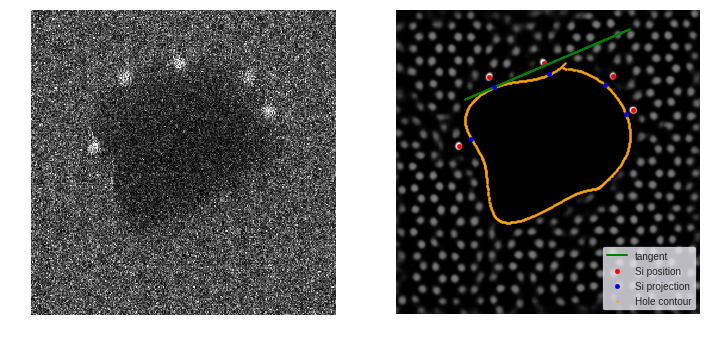

In [0]:
k = 11
si = 1
crs = 30

img_ ,img, coord, cnt = img_d_all[k].values()

coord = coord[np.where(coord[:,2]==1)][:,0:2]
coord = rem_coord(coord, crs)
cnt = interp_spline(cnt.T, s = 2000)
c = find_nn(coord, cnt)
tngnt, alpha = tangent(c[si], cnt)
y, x = coord.T
y1, x1 =  cnt[c].T
y2, x2 =  cnt.T

fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(121)
ax1.imshow(img_[:,:,0], cmap = 'gray')
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(img[:,:,0]+img[:,:,1]*2, cmap = 'gray', Interpolation = 'Gaussian')
ax2.scatter(x, y, c = 'red', s = 22, label = 'Si position')
ax2.scatter(x1, y1, c = 'blue', s = 22, zorder = 2, label = 'Si projection')
ax2.scatter(x2, y2, c = 'orange', s = 4, label = 'Hole contour')
ax2.plot(x2,tngnt(x2), linewidth = 2, c = 'green', label="tangent", zorder = 1)
legend = ax2.legend(loc = 'lower right', frameon = 1)
frame = legend.get_frame()
ax2.set_xlim(0, 256)
ax2.set_ylim(256, 0)
ax2.axis('off')

print(alpha[0])

We can optionally rotate the image such that tangent vector becomes perpendiculat to horizontal axis:

(we won't do any rotation in this analysis)

In [0]:
alpha_ = 0 
#alpha_ = alpha[0] - 90
img_r, coord0_r_all = rot(img, coord, alpha_)
_, coord_r_all = rot(img, cnt[c], alpha_)
_, cnt_r_all = rot(img, cnt, alpha_)
#img_r = (img_r - np.amin(img_r))/np.ptp(img_r)

We crop an image region centered around the Si defect of interest (the one for which we siplayed a tangent line) in the rotated image:

In [0]:
crs = 30
shift = 0
#si = 0

yi, xi = coord0_r_all[si]
xi = int(np.around(xi))
yi = int(np.around(yi)) - shift
mask_c = createCircularMask(img_r.shape[0], img_r.shape[1], center = (xi-0.5, yi-0.5), radius = crs)
img_r_m = np.copy(img_r)
img_r_m[~mask_c] = 0
img_rc = img_r_m[xi-crs:xi+crs,yi-crs:yi+crs]
#img_rc = ndimage.filters.gaussian_filter(img_rc, 0.5)

Plot the results:

(-0.5, 59.5, 59.5, -0.5)

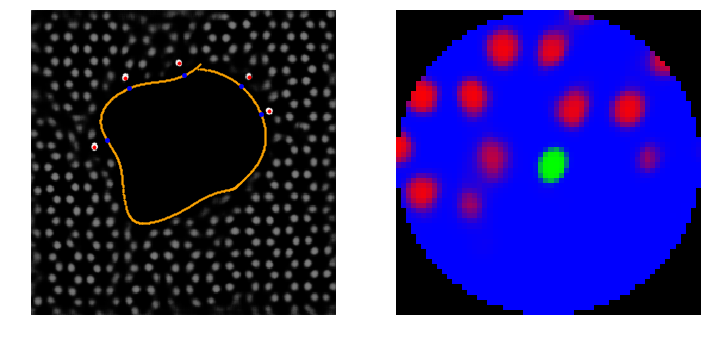

In [0]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax1.imshow(img_r[:,:,0] + img_r[:,:,1]*2 , cmap = 'gray')
x0_r, y0_r = coord0_r_all.T
x1_r, y1_r = coord_r_all.T
x2_r, y2_r = cnt_r_all.T
ax1.scatter(x0_r, y0_r, c = 'red', s = 12, label = 'Si position')
ax1.scatter(x2_r, y2_r, c = 'orange', s = 3, label = 'Hole contour')
ax1.scatter(x1_r, y1_r, c = 'blue', s = 22, zorder = 2, label = 'Si projection')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(img_rc, cmap = 'gray')
ax2.axis('off')

Now repeat it for all Si atoms and for each frame

In [0]:
img_rc_all = np.empty((0, int(crs*2), int(crs*2), 3))
frames = []
angles = []
for k, v in img_d_all.items():
    _,img, coord, cnt = v.values()
    coord = coord[np.where(coord[:,2]==1)][:,0:2]
    coord = rem_coord(coord, crs)
    cnt = interp_spline(cnt.T, s = 2000)
    c = find_nn(coord, cnt)
    for si, c1 in enumerate(c):
        if c1 >= len(cnt)-1:
            continue
        tngnt, alpha = tangent(c1, cnt)
        #alpha_ = alpha[0]-90
        alpha_ = 0
        img_r, coord0_r_all = rot(img, coord, alpha_)
        _, coord_r_all = rot(img, cnt[c], alpha_)
        _, cnt_r_all = rot(img, cnt, alpha_)
        yi, xi = coord0_r_all[si]
        xi = int(np.around(xi))
        yi = int(np.around(yi)) - shift
        mask_c = createCircularMask(
            img_r.shape[0], img_r.shape[1], center = (xi-0.5, yi-0.5), radius = crs)
        img_r_m = np.copy(img_r)
        img_r_m[~mask_c] = 0
        img_rc = img_r_m[xi-crs:xi+crs,yi-crs:yi+crs]
        if img_rc.shape == (int(crs*2), int(crs*2), 3):
            img_rc_all = np.append(img_rc_all, [img_rc], axis = 0)
            frames.append(k)  
            angles.append(alpha)

Save the extracted data

In [0]:
#np.save('Wobbly2-img_rc_all-final.npy', img_rc_all)
#np.save('frames.npy', frames)
#np.save('angles.npy', angles)

### 2. Clustering

In [0]:
from sklearn import cluster
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, decomposition, datasets

import copy
import itertools
from scipy import linalg

Load the data and "flatten" it for clustering:

In [0]:
img_rc_all = np.load('Wobbly2-img_rc_all-final.npy')

In [0]:
X_vec = img_rc_all.reshape(img_rc_all.shape[0], img_rc_all.shape[1]*img_rc_all.shape[2]*img_rc_all.shape[3])
print(X_vec.shape)

(1239, 10800)


#### Estimation of number of classes/clusters

We will use several methods for estimaing correct number of clusters, starting with hierarchical clustering dendrogram:

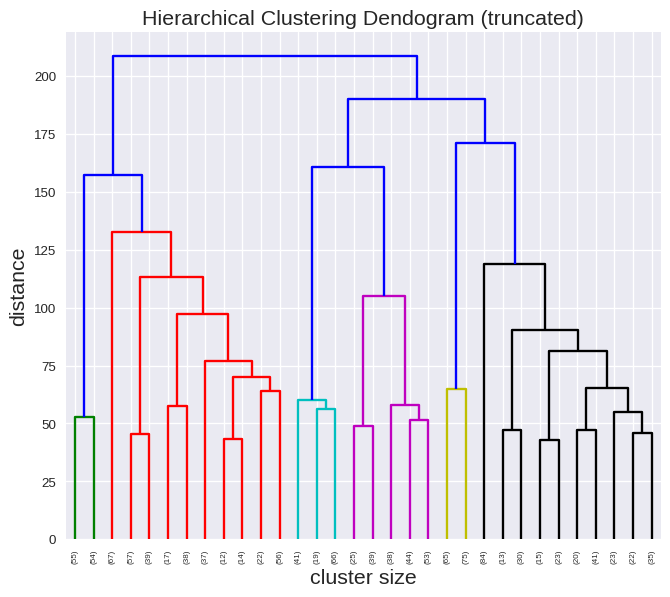

In [0]:
Z = linkage(X_vec, method='ward')
plt.figure(figsize = (8,7), dpi = 96)
dendrogram(Z, truncate_mode='lastp', p=32, leaf_rotation=90.,leaf_font_size=6.,)
plt.title('Hierarchical Clustering Dendogram (truncated)', fontsize = 16)
plt.xlabel('cluster size', fontsize = 16)
plt.ylabel('distance', fontsize = 16)
plt.show()

We can also explore the data variance with PCA:

(0, 50)

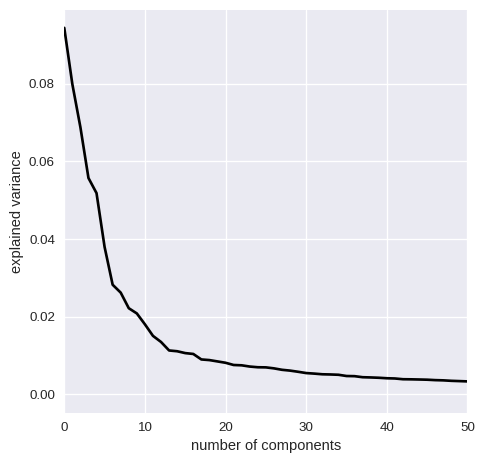

In [0]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(1, figsize=(6, 6), dpi = 96)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2, c = 'black')
plt.axis('tight')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xlim(0, 50)

#### Clustering/Unmixing

Run k-means clustering or Gaussian mixture model with selected number of components:

In [0]:
nc = 16
classifier = 'GMM'

if classifier == 'GMM':
    clf = mixture.GaussianMixture(n_components=nc, covariance_type='diag', random_state = 8000).fit(X_vec)
else:
    clf = KMeans(n_clusters=nc).fit(X_vec)

classes = clf.predict(X_vec) + 1

Plot (and save) the resultant components:

In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

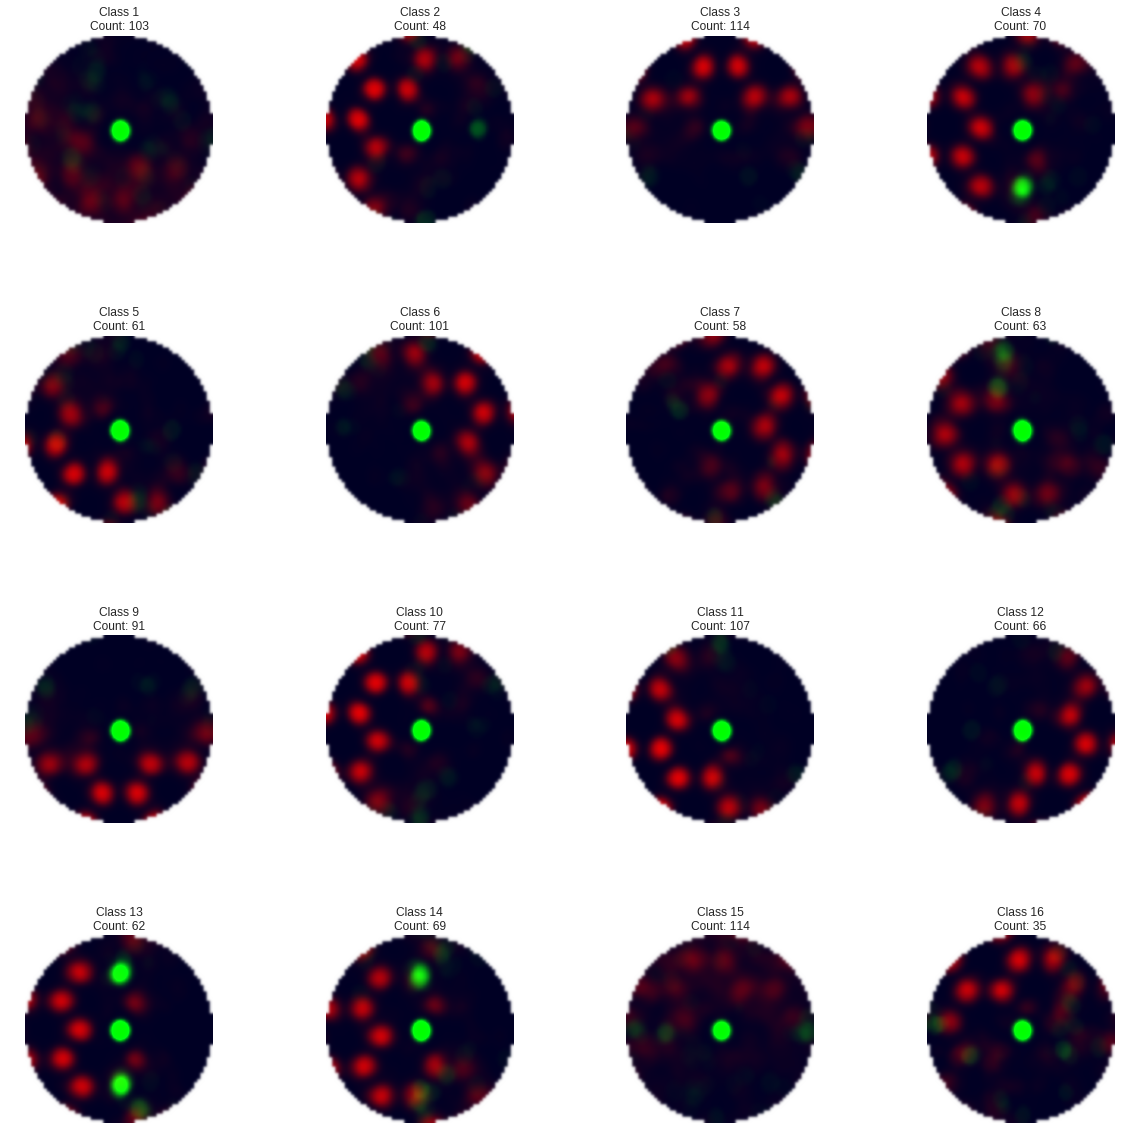

In [0]:
def enhance_clrs(cla_en, crs = crs, r1 = 1, r2 = 2, r3 = 1/7):
    '''image beautification (entirely optional)'''
    
    cla_en_C = cla_en[:,:,0]*r1
    cla_en_Si = cla_en[:,:,1]*r2
    cla_en_b = cla_en[:,:,2]*r3
    cla_en = np.concatenate((cla_en_C[:,:,None],
                             cla_en_Si[:,:,None],
                             cla_en_b[:,:,None]),
                             axis = 2)
    mask_c = createCircularMask(crs*2, crs*2, center = (crs-0.5, crs-0.5), radius = crs)
    cla_en[~mask_c] = 1
    return cla_en


cla = np.ndarray(shape=(np.amax(classes), int(crs*2), int(crs*2), 3))
fig = plt.figure(figsize=(20, 20))

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))

gs1 = gridspec.GridSpec(rows, cols)

for i in range(np.amax(classes)):
    cl = img_rc_all[classes == i + 1]
    cla[i] = np.mean(cl, axis=0)
    cla_en = np.copy(cla[i])
    cla_en = enhance_clrs(cla_en)
    ax = fig.add_subplot(gs1[i])
    ax.imshow(cla_en, Interpolation = 'Gaussian')
    
    ax.axis('off')
    ax.set_title('Class ' + str(i + 1) + '\nCount: ' + str(len(cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)

#### Analysis of structure rotations

We are now going to find which classes can be considered quasi-identical due to rotational symmetry of the system:

We'll need these libraries:

In [0]:
%%capture
!pip install imutils
import imutils
from skimage.measure import compare_ssim as ssim

Define  function(s) for finding classes connected by rotational symmetry:

In [0]:
def count_atoms(img1, img2, channel, t = 0.2, use_mask = False, **kwargs):
    '''Returns number of atoms of specific class/type
        channel = 0 for C, channel = 1 for Si'''
    
    radius = kwargs.get('radius')
    if radius == None:
        radius = img1.shape[0]/2
    img1_t = cv2.threshold(img1, t, 1, cv2.THRESH_BINARY)[1]
    img2_t = cv2.threshold(img2, t, 1, cv2.THRESH_BINARY)[1]
    if use_mask:
        w, h = img1.shape[0:2]
        mask = createCircularMask(w, h, center = (w/2-0.5, h/2-0.5), radius = radius)
        img1_t[~mask] = 0
        img2_t[~mask] = 0
    n_atom1 = ndimage.label(img1_t[:,:,channel])[1]
    n_atom2 = ndimage.label(img2_t[:,:,channel])[1]
    
    return n_atom1, n_atom2


def find_rotated_classes(
    classes, i, j, angles, sim_thresh=0.75, verbose = 0, natoms_constraint = True):
    '''Finds if a pair of images can be 
        mapped into each other by rotation operation.
        Returns structual similarity value and
        corresponding rotational angle'''
    
    if type(angles) is not np.ndarray:
        return None, None
    
    img1 = classes[i-1]
    img2 = classes[j-1]
    n_si1, n_si2 = count_atoms(img1, img2, 1)
    n_c1, n_c2 = count_atoms(img1, img2, 0, use_mask = True, radius = 15)
 
    img1 = np.uint8(img1*255)
    img2 = np.uint8(img2*255) 
    sims = []
    for angle in angles:
        img2_r = imutils.rotate(img2, angle)
        s = ssim(img1, img2_r, multichannel = True)
        sims.append(s)
        if natoms_constraint:
            f = bool(n_si1==n_si2 and n_c1==n_c2)
        else:
            f = True
    if max(sims) >= sim_thresh and f == True:
        idx = sims.index(max(sims))
        rot_ang = angles[idx]
        if verbose == 1:
            img2_r = imutils.rotate(classes[j-1], rot_ang)
            print('\nClasses ' + str(i) + ' and ' + str(j) +
                  ' can be the same class rotated by ' + str(rot_ang) + ' degrees.'
                 '\nSimilarity is ' + str(np.around(max(sims), decimals = 2)))
            fig = plt.figure(figsize = (8,8))
            ax1 = fig.add_subplot(121)
            ax1.imshow(classes[i-1])
            ax1.set_title('Class ' + str(i))
            ax1.grid('off')
            ax2 = fig.add_subplot(122)
            ax2.imshow(img2_r)
            ax2.set_title('Class ' + str(j) + ' rotated by ' + str(rot_ang))
            ax2.grid('off')
            plt.show()
        return max(sims), rot_ang 
    
    if verbose == 1:
        print('Classes ' + str(i) + ' and ' + str(j) + ': No match was found')
    return max(sims), None

Test it for a single pair of classes: 


Classes 2 and 6 can be the same class rotated by 120 degrees.
Similarity is 0.78


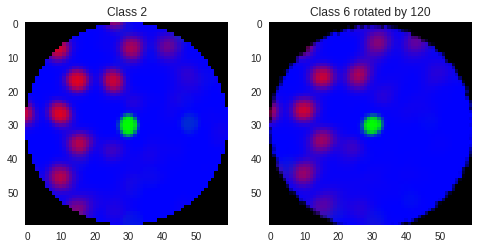

In [0]:
angles_ = np.arange(60, 360, 60) 
i = 2 # configuration/class
j = 6 # class/configuration to which we will compare

a,b = find_rotated_classes(cla, i, j, angles_, sim_thresh = 0.5, verbose = 1)

Now do the same for all the cases:

In [0]:
angles_ = np.empty((0, 1))
for ang in np.arange(0, 301, 60):
    angles_ = np.append(angles_, np.arange(ang-5, ang+6, 1))

Classes 1 and 2: No match was found
Classes 1 and 3: No match was found
Classes 1 and 4: No match was found
Classes 1 and 5: No match was found
Classes 1 and 6: No match was found
Classes 1 and 7: No match was found
Classes 1 and 8: No match was found
Classes 1 and 9: No match was found
Classes 1 and 10: No match was found
Classes 1 and 11: No match was found
Classes 1 and 12: No match was found
Classes 1 and 13: No match was found
Classes 1 and 14: No match was found
Classes 1 and 15: No match was found
Classes 1 and 16: No match was found
Classes 2 and 1: No match was found
Classes 2 and 3: No match was found
Classes 2 and 4: No match was found
Classes 2 and 5: No match was found

Classes 2 and 6 can be the same class rotated by 122.0 degrees.
Similarity is 0.8


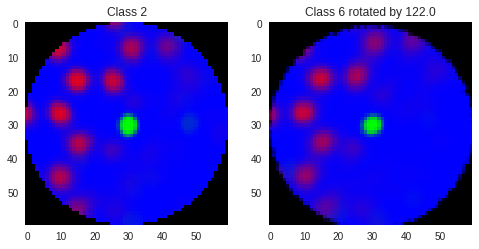

Classes 2 and 7: No match was found
Classes 2 and 8: No match was found
Classes 2 and 9: No match was found

Classes 2 and 10 can be the same class rotated by 3.0 degrees.
Similarity is 0.79


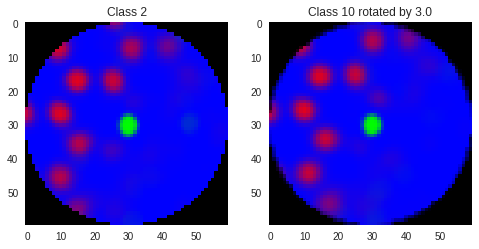


Classes 2 and 11 can be the same class rotated by 302.0 degrees.
Similarity is 0.85


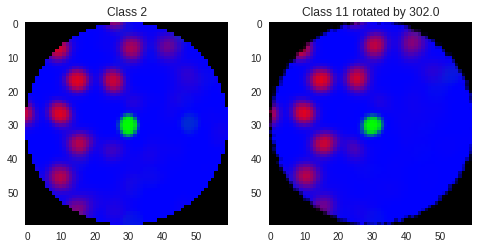

Classes 2 and 12: No match was found
Classes 2 and 13: No match was found
Classes 2 and 14: No match was found
Classes 2 and 15: No match was found
Classes 2 and 16: No match was found
Classes 3 and 1: No match was found
Classes 3 and 2: No match was found
Classes 3 and 4: No match was found
Classes 3 and 5: No match was found
Classes 3 and 6: No match was found
Classes 3 and 7: No match was found
Classes 3 and 8: No match was found

Classes 3 and 9 can be the same class rotated by 181.0 degrees.
Similarity is 0.86


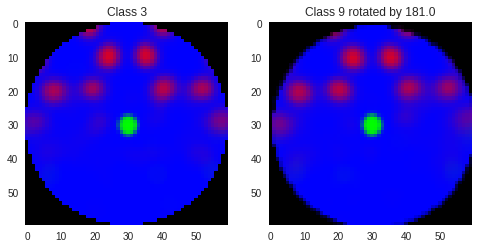

Classes 3 and 10: No match was found
Classes 3 and 11: No match was found

Classes 3 and 12 can be the same class rotated by 119.0 degrees.
Similarity is 0.88


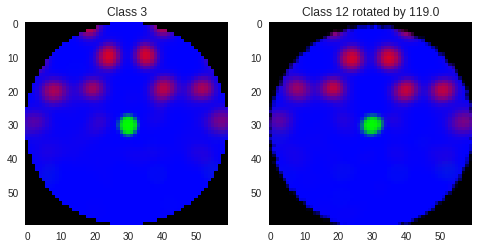

Classes 3 and 13: No match was found
Classes 3 and 14: No match was found
Classes 3 and 15: No match was found
Classes 3 and 16: No match was found
Classes 4 and 1: No match was found
Classes 4 and 2: No match was found
Classes 4 and 3: No match was found
Classes 4 and 5: No match was found
Classes 4 and 6: No match was found
Classes 4 and 7: No match was found
Classes 4 and 8: No match was found
Classes 4 and 9: No match was found
Classes 4 and 10: No match was found
Classes 4 and 11: No match was found
Classes 4 and 12: No match was found
Classes 4 and 13: No match was found
Classes 4 and 14: No match was found
Classes 4 and 15: No match was found
Classes 4 and 16: No match was found
Classes 5 and 1: No match was found
Classes 5 and 2: No match was found
Classes 5 and 3: No match was found
Classes 5 and 4: No match was found

Classes 5 and 6 can be the same class rotated by 178.0 degrees.
Similarity is 0.76


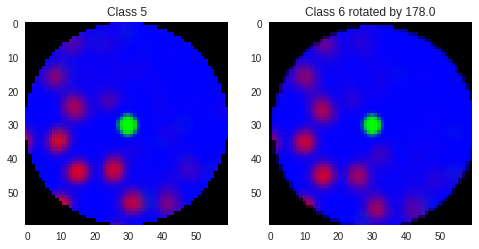

Classes 5 and 7: No match was found
Classes 5 and 8: No match was found
Classes 5 and 9: No match was found

Classes 5 and 10 can be the same class rotated by 59.0 degrees.
Similarity is 0.83


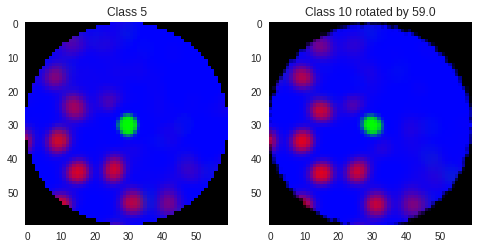

Classes 5 and 11: No match was found
Classes 5 and 12: No match was found
Classes 5 and 13: No match was found
Classes 5 and 14: No match was found
Classes 5 and 15: No match was found
Classes 5 and 16: No match was found
Classes 7 and 1: No match was found
Classes 7 and 2: No match was found
Classes 7 and 3: No match was found
Classes 7 and 4: No match was found
Classes 7 and 5: No match was found
Classes 7 and 6: No match was found
Classes 7 and 8: No match was found
Classes 7 and 9: No match was found
Classes 7 and 10: No match was found
Classes 7 and 11: No match was found
Classes 7 and 12: No match was found
Classes 7 and 13: No match was found
Classes 7 and 14: No match was found
Classes 7 and 15: No match was found
Classes 7 and 16: No match was found
Classes 8 and 1: No match was found
Classes 8 and 2: No match was found
Classes 8 and 3: No match was found
Classes 8 and 4: No match was found
Classes 8 and 5: No match was found
Classes 8 and 6: No match was found
Classes 8 and 7

In [0]:
# Initial assesment
sim_thresh = 0.75
cl_eq_d = {} # dictionary of classes related by rotations
cl_rot_ang_d = {} # dictionary of rotation angles that relate different classes to each other
for i in range(cla.shape[0]): 
    i_ = i + 1
    if [i_ for v in cl_eq_d.values() if i_ in v]:
        continue
    cl_eq = []
    cl_rot_ang = []
    for j in range(cla.shape[0]):
        j_ = j + 1
        angles = None if i_ == j_ else angles_
        max_sim, rot_ang = find_rotated_classes(
            cla, i_, j_, angles, sim_thresh = sim_thresh, verbose = 1)
        if rot_ang is not None:
            cl_eq.append(j_)
            cl_rot_ang.append(rot_ang)
            cl_eq_d[i_] = cl_eq  
            cl_rot_ang_d[i_] = cl_rot_ang

# Refinement
cl_comb = []
keys_to_del = []
for k, v in sorted(cl_eq_d.items()):
    k_ =  [k_ for k_, v_ in cl_eq_d.items() if len(set(v).intersection(v_)) > 0 and k != k_]
    if len(k_) > 0 and tuple((k_[0], k)) not in cl_comb:
        cl_comb.append(tuple((k, k_[0])))
        print('\nAdditional refinement: adding class', str(k_[0]),
              'and its rotational invariants to class', str(k))
        keys_to_del.append(k_[0])
        for v_rot, ang_rot in zip(cl_eq_d[k_[0]], cl_rot_ang_d[k_[0]]):
            if k_[0] not in cl_eq_d[k]:
                cl_eq_d[k].append(k_[0])
                cl_rot_ang_d[k].append(find_rotated_classes(
                    cla, k, k_[0], angles_, sim_thresh = 0.,
                    natoms_constraint = False)[1])
            if v_rot not in cl_eq_d[k]:
                cl_eq_d[k].append(v_rot) 
                cl_rot_ang_d[k].append(ang_rot)               
for k in keys_to_del:
    cl_eq_d.pop(k, None)
    cl_rot_ang_d.pop(k, None)

We can view the classes identified as related to each other by rotations:

In [0]:
for k, v in sorted(cl_eq_d.items()):
    print('Class {} is rotationally invariant to classes: {}'.format(k, v))

Class 2 is rotationally invariant to classes: [6, 10, 11, 5]
Class 3 is rotationally invariant to classes: [9, 12]


Let's copy make a copy of the created dictionaries:

In [0]:
cl_eq_d_ = copy.deepcopy(cl_eq_d)
cl_rot_ang_d_ = copy.deepcopy(cl_rot_ang_d)

Because the automated search did not identify all the classes rotated by rotational symmetry, we will do a manual refinement now. See main text of the corresponding paper for details. We do additional combining of classes using (several times) code in the cell below:

In [0]:
# Add this class
j = 14
# To this class
i = 4

ang = find_rotated_classes(cla, i, j, angles_, sim_thresh = 0.1)[1]
if i in cl_eq_d_.keys():
    cl_eq_d_[i].append(j)
    cl_rot_ang_d_[i].append(ang)
else:
    cl_eq_d_[i] = [j]
    cl_rot_ang_d_[i] = [ang]

Now plot the grouped classes:

In [0]:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'green', 'darkviolet', 'gold', 'pink', 'red', 'yellow', 'maroon', 'orangered', 'lime', 'darkblue']

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


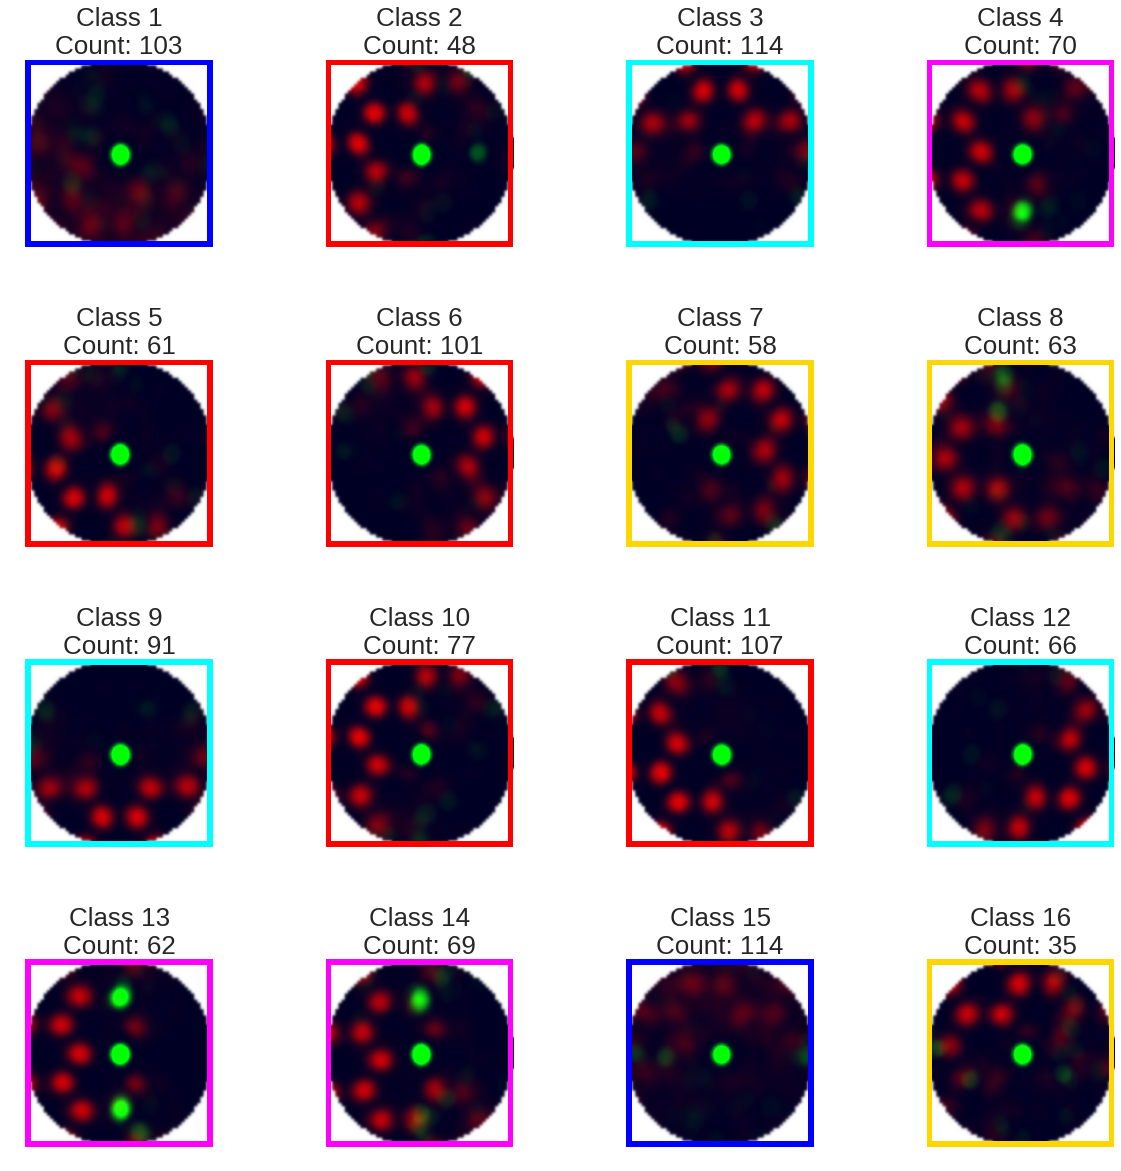

In [0]:
def enhance_clrs(cla_en, crs = crs):
    '''image beautification (entirely optional)'''
    
    cla_en_C = cla_en[:,:,0]
    cla_en_Si = cla_en[:,:,1]*2
    cla_en_b = cla_en[:,:,2]/7
    cla_en = np.concatenate((cla_en_C[:,:,None],
                             cla_en_Si[:,:,None],
                             cla_en_b[:,:,None]),
                             axis = 2)
    mask_c = createCircularMask(crs*2, crs*2, center = (crs-0.5, crs-0.5), radius = crs)
    cla_en[~mask_c] = 1
    return cla_en


cla = np.ndarray(shape=(np.amax(classes), int(crs*2), int(crs*2), 3))
fig = plt.figure(figsize=(20, 20))

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))

gs1 = gridspec.GridSpec(rows, cols)

for i in range(np.amax(classes)):
    cl = img_rc_all[classes == i + 1]
    cla[i] = np.mean(cl, axis=0)
    cla_en = np.copy(cla[i])
    cla_en = enhance_clrs(cla_en)
    ax = fig.add_subplot(gs1[i])
    ax.imshow(cla_en, Interpolation = 'Gaussian')
    
    ax.axis('off')
    ax.set_title('Class ' + str(i + 1) + '\nCount: ' + str(len(cl)), fontsize = 26)

for i in range(1, np.amax(classes)+1):
    if i in cl_eq_d_.keys():
        cl_eq_l = cl_eq_d_[i]
        cl_eq_l.append(i)
        for v in cl_eq_l:
            ax = fig.add_subplot(gs1[v-1])
            p = patches.Rectangle( (0, 0), crs*2-1, crs*2-1, fill=False, color = colors[i], lw=8)
            ax.add_patch(p)
    
plt.subplots_adjust(hspace=0.6, wspace=0.4)

Average images of classes, which were determined to be the same defect type:

In [0]:
from collections import OrderedDict
cla_used = []
cla_av_all = {}
for (key, val), (key_r,val_r) in zip(sorted(cl_eq_d_.items()), sorted(cl_rot_ang_d_.items())):
    cla_av = np.zeros((len(val), cla.shape[1], cla.shape[2], cla.shape[3]))
    cla_used.append(key)
    dictionary = OrderedDict()
    for i, (v, v_r) in enumerate(zip(val, val_r)):
        cla_av[i,:,:,:] = imutils.rotate(cla[v-1], v_r)
        cla_used.append(v)
    count = sum([np.where(classes == c)[0].shape[0] for c in cl_eq_d_[key]]) + np.where(classes == key)[0].shape[0]
    dictionary['class count'] = count
    dictionary['class image'] = np.mean(cla_av, axis = 0)
    cla_av_all[key] = dictionary 
    
for idx, cl in enumerate(cla):
    idx_ = idx + 1
    dictionary = OrderedDict()
    if idx_ not in set(cla_used):
        count = np.where(classes == idx_)[0].shape[0]
        dictionary['class count'] = count
        dictionary['class image'] = cl
        cla_av_all[idx_] = dictionary

Plot the averaged images:

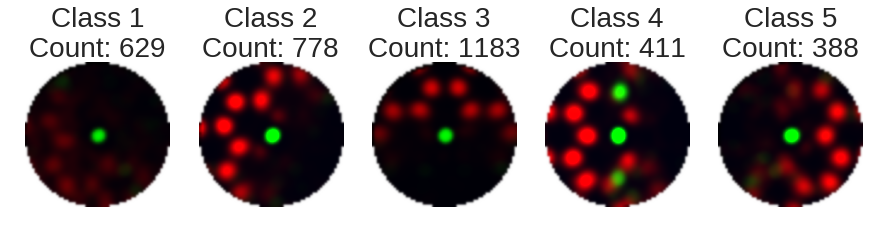

In [0]:
fig = plt.figure(figsize=(15, 15))

rows = 1
cols = 5

gs = gridspec.GridSpec(rows, cols)

for i, k in enumerate(sorted(cla_av_all.keys())):
    cla_en = cla_av_all[k]['class image']
    cla_en_ = np.copy(cla_en)
    cla_en_ = enhance_clrs(cla_en_)
    ax = fig.add_subplot(gs[i])
    ax.imshow(cla_en_, Interpolation = 'Gaussian')
    ax.axis('off')
    ax.set_title('Class ' + str(i+1) +  '\nCount: ' + str(cla_av_all[k]['class count']), fontsize = 28)

#plt.subplots_adjust(hspace=0.6, wspace=0.4)

In [0]:
#np.save('Wobbly2-dict_classes.npy', cla)
#np.save('Wobbly2-dict-rot.npy', cl_eq_d_)
#np.save('Wobbly2-dict-rot-ang.npy', cl_rot_ang_d_)

Renumerate classes based on the analysys above:

In [0]:
classes_r = np.copy(classes)
for k, v in cl_eq_d_.items():
    for v_ in v:
        classes_r[np.where(classes_r == v_)] = k

### Markov transitions

Renumerate (if necessary) classes for Markov analysis:

In [0]:
classes_f = classes_r.copy()
diff = np.unique(classes_f) - np.arange(len(np.unique(classes_f)))
diff_d = {}
for d, cl in zip(diff, np.unique(classes_f)):
    diff_d[cl] = d
classes_f_n = []
for cl in classes_f:
    cl_new = cl - diff_d[cl]
    classes_f_n.append(cl_new)
classes_f_n = np.array(classes_f_n)

We define a function to get probabilities from observations

In [0]:
def transition_matrix(trace):
    n = 1+ max(trace) #number of states
    
    M = np.zeros(shape=(n, n))  
    for (i,j) in zip(trace,trace[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

Calculate transition probabilities between classes determined from Gaussian mixture model

In [0]:
m = transition_matrix(classes_f_n)

Plot the resultant transition matrix:

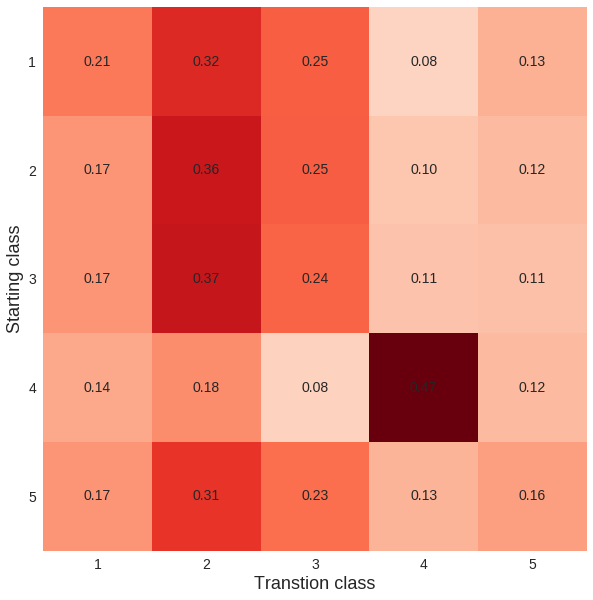

In [0]:
m_ = np.concatenate((np.zeros((1, m.shape[1])), m), axis = 0)
m_ = np.concatenate((np.zeros((m_.shape[0], 1)), m_), axis = 1)
xt = np.arange(len(m)+1)
yt = np.arange(len(m)+1)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(m_, cmap='Reds')
ax.set_xticks(xt)
ax.set_yticks(yt)
ax.set_xticklabels(xt, fontsize=14)  
ax.set_yticklabels(xt, fontsize=14)  
ax.set_xlabel('Transtion class', fontsize = 18)
ax.set_ylabel('Starting class', fontsize = 18)
ax.grid('off')
ax.set_xlim(0.5, len(m)+0.5)
ax.set_ylim(len(m)+0.5, 0.5)

for (j,i),label in np.ndenumerate(m_):
    if i !=0 and j !=0:
        ax.text(i,j, "%.2f" % label, ha='center',va='center', fontsize = 14)